In [1]:
# STEP 1: Install Kaggle API
!pip install -q kaggle

# STEP 2: Upload kaggle.json (your API token)
from google.colab import files
files.upload()  # Choose your kaggle.json here

# STEP 3: Setup Kaggle API key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 4: Download the dataset from Kaggle
!kaggle datasets download -d dhananjayka/isl-dataset-spit

# STEP 5: Load image directly from zip
from zipfile import ZipFile
from PIL import Image
from io import BytesIO

zip_path = 'isl-dataset-spit.zip'  # Make sure this matches downloaded file name

# STEP 6: Open and preview image inside zip
with ZipFile(zip_path, 'r') as archive:
    img_names = archive.namelist()
    print(f"Total images found: {len(img_names)}")

    # Just show the first image
    with archive.open(img_names[0]) as file:
        img = Image.open(file)
        img.show()

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dhananjayka/isl-dataset-spit
License(s): unknown
Total images found: 13796


In [2]:
from zipfile import ZipFile

# Change 'isl.zip' to 'isl-dataset-spit.zip' to match the downloaded filename.
with ZipFile('isl-dataset-spit.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/isl_dataset')

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:

# Path to dataset
dataset_path = './isl_dataset'  # Ensure this matches your dataset path
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Image size for resizing (suitable for CNN)
IMAGE_SIZE = (64, 64)  # Common size for CNN input
CHANNELS = 1  # Grayscale (use 3 for RGB)

# Lists to store data and labels
image_data = []
labels = []

# Walk through each folder (label) and its image files
for dirpath, dirnames, filenames in os.walk(dataset_path):
    for file in filenames:
        if file.lower().endswith(image_extensions):
            label = os.path.basename(dirpath)
            full_path = os.path.join(dirpath, file)

            # Open image and resize
            img = Image.open(full_path).convert('L')  # Grayscale (use 'RGB' for color)
            img = img.resize(IMAGE_SIZE)

            # Convert image to numpy array (keep 2D structure for CNN)
            img_array = np.array(img)

            # If using RGB, comment out the next line and use CHANNELS = 3 above
            img_array = img_array[..., np.newaxis]  # Add channel dimension for grayscale (shape: 64, 64, 1)

            image_data.append(img_array)
            labels.append(label)

# Convert lists to numpy arrays
X = np.array(image_data)
y = np.array(labels)

print("Image data shape:", X.shape)  # Should be (num_images, 64, 64, 1) for grayscale
print("Labels shape:", y.shape)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Normalize pixel values to [0, 1] (important for CNNs)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

Image data shape: (13796, 64, 64, 1)
Labels shape: (13796,)


In [99]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,151,322 (4.39 MB)

 Trainable params: 1,151,322 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [102]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [103]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=callback, batch_size=32)


Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5671 - loss: 1.5434 - val_accuracy: 0.9760 - val_loss: 0.1132
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9841 - loss: 0.0632 - val_accuracy: 0.9832 - val_loss: 0.0781
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9933 - loss: 0.0278 - val_accuracy: 0.9814 - val_loss: 0.0752
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9940 - loss: 0.0198 - val_accuracy: 0.9878 - val_loss: 0.0720
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9930 - loss: 0.0239 - val_accuracy: 0.9855 - val_loss: 0.0828
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9950 - loss: 0.0168 - val_accuracy: 0.9832 - val_loss: 0.0789
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9975 - loss: 0.0118 - val_accuracy: 0.9882 - val_loss: 0.0761
Epoch 8/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9959 - loss: 0.0191 - val_acc

In [104]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9922 - loss: 0.0796

Test accuracy: 0.9924


In [105]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


0.9923913043478261

In [106]:
y_prob1 = model.predict(X_train)
y_pred1 = y_prob1.argmax(axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(y_train,y_pred1)

345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


0.9980065241029359

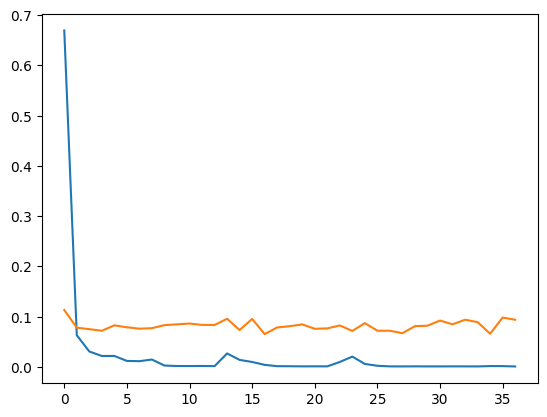

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

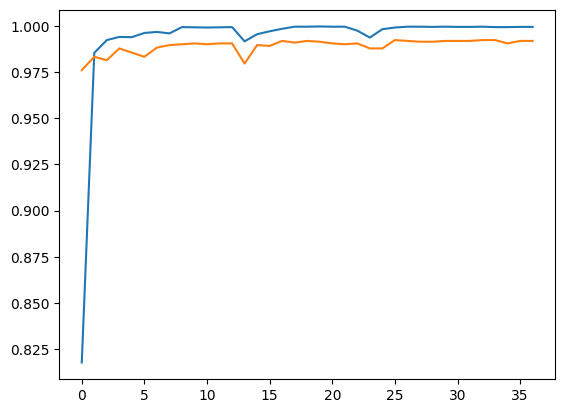

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [162]:
from tensorflow.keras.models import model_from_json


In [163]:
model_json = model.to_json()
with open("model.json", "w") as json_file: # Change filename to 'model.json'
    json_file.write(model_json)

In [164]:
model.save_weights("model_weights.weights.h5") # Changed the filename to include '.weights' before '.h5'

In [158]:
import cv2
import numpy as np
import json

def preprocess_image_for_prediction(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
    img = cv2.resize(img, (64,64))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1) # Add channel dimension for grayscale (shape: 1, 64, 64, 1)
    return img

def predict_image(model, img): # Added label_encoder as an argument

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    # Instead of loading from 'class_indices.json', use label_encoder
    # predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_class_index, confidence


In [161]:
image_path = '/content/U_NEW.jfif'
img = preprocess_image_for_prediction(image_path)
predicted_label, confidence = predict_image(model, img)  # Pass label_encoder
print(f"Predicted Letter: {predicted_label}, Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Letter: 20, Confidence: 1.0000
